In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
salader_dogs_vs_cats_path = kagglehub.dataset_download('salader/dogs-vs-cats')

print('Data source import complete.')

100%|██████████| 1.06G/1.06G [00:07<00:00, 148MB/s]

Extracting files...


Data source import complete.


In [4]:
print(salader_dogs_vs_cats_path)

/root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1


# Importing Important Libraries

In [2]:
#Import Os and Basis Libraries
import cv2
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
#Matplot Images
import matplotlib.image as mpimg
# Tensflor and Keras Layer and Model and Optimize and Loss
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import *
from tensorflow.keras.losses import BinaryCrossentropy
# import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam
#PreTrained Model VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception
#Image Generator DataAugmentation
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
# Warnings Remove
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Directory containing the "Train" folder
directory = "/root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1"

# List of categories (subfolder names)
categories = ["cats", "dogs"]

# Initialize lists to store filenames and categories
filenames = []
category_labels = []

# Iterate through the categories
for category in categories:
    # Path to the current category folder
    category_folder = os.path.join(directory, "train", category)
    # List all filenames in the category folder
    category_filenames = os.listdir(category_folder)
    # Append filenames and corresponding category labels
    filenames.extend(category_filenames)
    category_labels.extend([category] * len(category_filenames))

# Create DataFrame
df = pd.DataFrame({
    'filename': filenames,
    'category': category_labels
})

# Display the first few rows of the DataFrame
print(df.head())
print(df.shape)

        filename category
0   cat.7539.jpg     cats
1  cat.10396.jpg     cats
2   cat.1755.jpg     cats
3   cat.8098.jpg     cats
4   cat.7462.jpg     cats
(20000, 2)


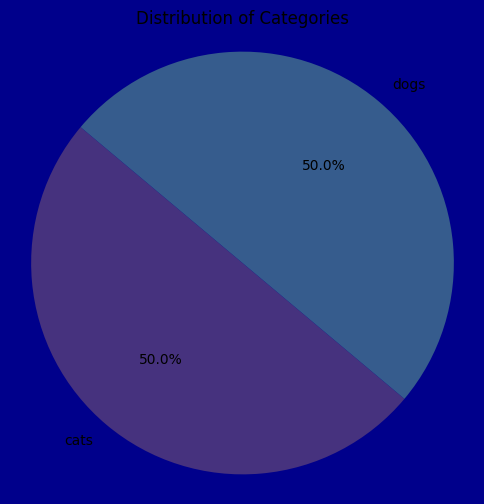

In [7]:
# Count the occurrences of each category in the 'category' column
count = df['category'].value_counts()

# Create a pie chart using Seaborn
plt.figure(figsize=(6, 6) , facecolor='darkblue')
palette = sns.color_palette("viridis")
sns.set_palette(palette)
plt.pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Categories')
plt.axis('equal')

plt.show()  # Show the plot

# Data Preview

In [8]:
def visualize_images(path, num_images=5):
    # Get a list of image filenames in the specified path
    image_filenames = os.listdir(path)

    # Limit the number of images to visualize if there are more than num_images
    num_images = min(num_images, len(image_filenames))

    # Create a figure and axis object to display images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3),facecolor='darkblue')

    # Iterate over the selected images and display them
    for i, image_filename in enumerate(image_filenames[:num_images]):
        # Load the image using Matplotlib
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)

        # Display the image
        axes[i].imshow(image)
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(image_filename)  # Set image filename as title

    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

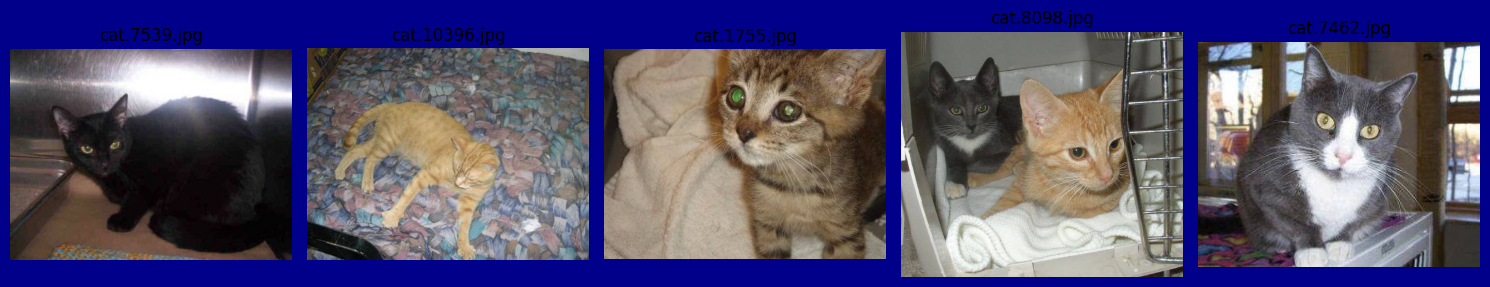

In [10]:
# Specify the path containing the images to visualize
path_to_visualize = "/root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1/train/cats"

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

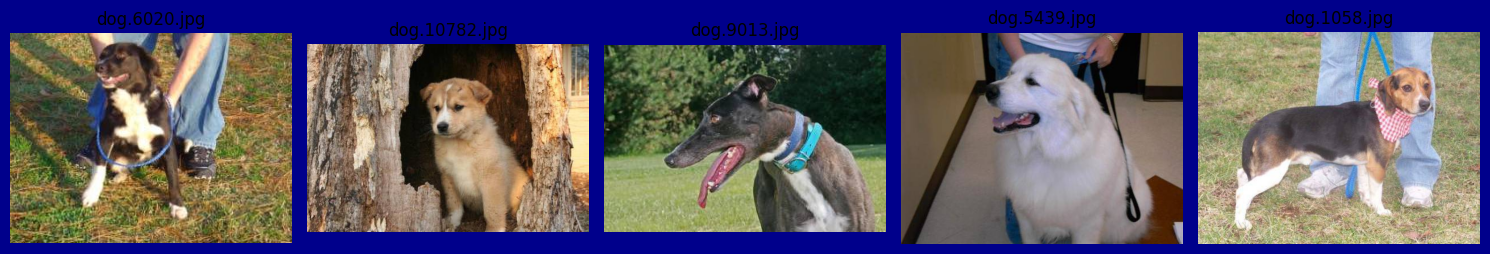

In [11]:
# Specify the path containing the images to visualize
path_to_visualize = "/root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1/train/dogs"

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

In [12]:
seed = 123

#Data_Dir
data_dir = '/root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1/train'

# Defining data generator with Data Augmentation
data_gen_augmented = ImageDataGenerator(
    rescale = 1/255.,
    validation_split = 0.2,
    zoom_range = 0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range = 20,
    horizontal_flip= True,
)
print('Augmented training Images:')
train_ds = data_gen_augmented.flow_from_directory(
    data_dir,
    target_size = (256, 256),
    batch_size = 32,
    subset = 'training',
    class_mode = 'binary',
    seed =seed,
)

#Testing Augmented Data
# Defining Validation_generator withour Data Augmentation
data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

print('Unchanged Validation Images:')
validation_ds = data_gen.flow_from_directory(data_dir,
    target_size = (256, 256),
    batch_size = 32,
    subset = 'validation',
    class_mode = 'binary')

Augmented training Images:
Found 16000 images belonging to 2 classes.
Unchanged Validation Images:
Found 4000 images belonging to 2 classes.


In [13]:
# Get the directory path from the DirectoryIterator object
dataset_path = '/root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1/train'

# Count the number of subdirectories (classes)
num_classes = len([name for name in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, name))])

print("Number of classes:", num_classes)

Number of classes: 2


# Model architechture

In [17]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense, Dropout

# Load the MobileNetV2 model (pre-trained on ImageNet)
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the base model (to keep pre-trained weights)
mobilenet_base.trainable = False

# Build the model using Sequential API
model = Sequential()

# Add the MobileNetV2 base model
model.add(mobilenet_base)

# Add global average pooling to reduce spatial dimensions
model.add(AveragePooling2D(pool_size=(7, 7)))

# Flatten the feature maps
model.add(Flatten())

# Add a fully connected layer
model.add(Dense(220, activation='relu'))

# Add dropout to prevent overfitting
model.add(Dropout(0.3))

# Add the output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

In [18]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
# Summary of the model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 1, 1, 1280)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 220)                 │         281,820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 220)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             221 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,540,025 (9.69 MB)

 Trainable params: 282,041 (1.08 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Traning the model

In [20]:
from tensorflow.keras.callbacks import EarlyStopping  # Import EarlyStopping callback

# Train the model with early stopping to prevent overfitting
history = model.fit(
    train_ds,  # Training dataset
    epochs=10,  # Maximum number of epochs for training
    steps_per_epoch = len(train_ds),
    validation_data=validation_ds,  # Validation dataset for performance monitoring
    validation_steps = len(validation_ds),
    callbacks=[
        EarlyStopping(
            min_delta=0.001, # minimium amount of change to count as an improvement
            monitor='val_loss',  # Monitor validation loss to decide when to stop training
            patience=3,  # Stop training if validation loss does not improve for 3 consecutive epochs
            restore_best_weights=True  # Restore the model weights from the best epoch
        )
    ]
)

Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1402s 3s/step - accuracy: 0.9566 - loss: 0.1142 - val_accuracy: 0.9753 - val_loss: 0.0702
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1380s 3s/step - accuracy: 0.9731 - loss: 0.0723 - val_accuracy: 0.9837 - val_loss: 0.0455
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1387s 3s/step - accuracy: 0.9750 - loss: 0.0643 - val_accuracy: 0.9855 - val_loss: 0.0408
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9750 - loss: 0.0631

KeyboardInterrupt: 

In [27]:
# Evaluate the model on the validation dataset
train_loss, train_acc = model.evaluate(train_ds)
val_loss, val_acc = model.evaluate(validation_ds)

500/500 ━━━━━━━━━━━━━━━━━━━━ 1167s 2s/step - accuracy: 0.9792 - loss: 0.0486
125/125 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.9762 - loss: 0.0560


In [29]:
print(train_loss, train_acc)
print(val_loss, val_acc)

[0.048889923840761185, 0.048889923840761185, 0.048889923840761185, 0.048889923840761185] 0.9794374704360962
[0.04833468049764633, 0.04833468049764633, 0.04833468049764633, 0.04833468049764633] 0.9804999828338623


# Visualizing the performance of the model

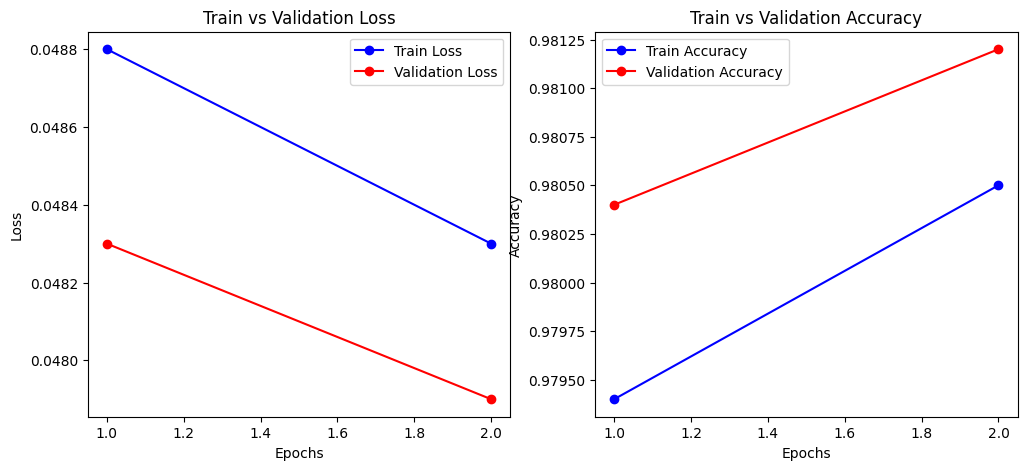

In [39]:
import matplotlib.pyplot as plt

# Example data (assumed collected over epochs)
train_loss = [[0.0488, 0.0488, 0.0488, 0.0488], [0.0483, 0.0483, 0.0483, 0.0483]]  # Loss per epoch
val_loss = [[0.0483, 0.0483, 0.0483, 0.0483], [0.0479, 0.0479, 0.0479, 0.0479]]
train_acc = [0.9794, 0.9805]  # Accuracy per epoch
val_acc = [0.9804, 0.9812]

# Convert loss lists to mean values
train_loss_mean = [sum(epoch_loss) / len(epoch_loss) for epoch_loss in train_loss]
val_loss_mean = [sum(epoch_loss) / len(epoch_loss) for epoch_loss in val_loss]

epochs = range(1, len(train_acc) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_mean, 'b-o', label='Train Loss')
plt.plot(epochs, val_loss_mean, 'r-o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-o', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.show()


# Checking with unseen data

In [47]:
import cv2
import numpy as np

def predict_cat_or_dog(model, image_path):
    """
    Predicts whether the given image is a cat or a dog.

    Args:
        model: Trained CNN model.
        image_path: Path to the image file.

    Returns:
        str: "Cat" if prediction < 0.5, else "Dog".
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        return "Error: Image not found!"

    # Resize to match model's input size
    image = cv2.resize(image, (256, 256))

    # Normalize (scale pixel values between 0 and 1)
    image = image / 255.0

    # Expand dimensions to match model's expected input shape (batch size of 1)
    image = np.expand_dims(image, axis=0)

    # Make prediction
    pred = model.predict(image)

    # Convert prediction to label
    return "This is most probably a Cat 😺" if pred[0][0] < 0.5 else "This is most probably a Dog 🐶"

# Example usage
image_path1 = '/root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1/test/cats/cat.10086.jpg'
image_path2 = "/root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1/test/dogs/dog.10102.jpg"
result1 = predict_cat_or_dog(model, image_path1)
result2 = predict_cat_or_dog(model, image_path2)
print(result1)
print(result2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
This is most probably a Cat 😺
This is most probably a Dog 🐶
